# Style Gan 본인 Self 학습자료. 직접 본인이 100% 공부한 자료.
## 주제: StyleGAN을 활용한 얼굴 편집(Face Editing)
### 주제 설명
 * GAN은 생성 모델(Generative Model)의 일종으로, 실제로 존재하지는 않지만 있을 법한 데이터를 생성할 수 있도록 하는 기술이다. 
   FFHQ(고해상도 얼굴 데이터셋)로 학습된 StyleGAN을 이용하여 다양한 고해상도 얼굴 이미지를 만들 수 있는 것이다.
   StyleGAN은 고해상도 사람 얼굴을 만들 수 있을 뿐만 아니라 얼굴 편집(Face Editing)을 위해 활용할 수 있다. 얼굴 편집 기술은 다양한 뷰티/    사진 앱에서 활용되고 있는 기술로 남성을 여성으로 바꾸는 등 사람의 얼굴을 다양한 형태로 편집할 수 있도록 한다.

  * 본 실습에서는 다음의 얼굴 편집 핵심 기술들을 학습하는 것을 목표로 한다.
   * 얼굴 생성(Face Generation): 있을법한 임의의 얼굴을 생성한다.
   * 얼굴 모핑(Face Morphing): 두 얼굴을 상호 간 서서히 변화시킨다.
   * 얼굴 임베딩(Face Embedding): 특정한 사람 이미지에 해당하는 임베딩을 찾는다.
   * 얼굴 교차(Face Crossover): 두 얼굴을 절반씩 섞은 이미지를 생성한다.
   * 임베딩 벡터 연산(Latent Vector Arithmetic): 얼굴 임베딩끼리의 연산을 통해 시맨틱(Semantic) 정보를 추출한다.
   * 시맨틱 정보 변경(Semantic Editing): 이미지의 다양한 시맨틱 특징을 조절한다.
   * 스타일 전송(Style Transfer): 다른 이미지로 스타일을 전송한다.
   * 얼굴 복구(Face Reconstruction): 오염된 얼굴 이미지를 복구한다.

## 사용한 데이터셋
 * 데이터 소개
    이번 주제에서 사용하는 데이터셋은 다음과 같다.
    FFHQ 데이터셋: 고해상도 얼굴 이미지 데이터셋
    CelebA 데이터셋: 유명인 얼굴 데이터셋

## 최종 목표
- 얼굴 생성 및 편집 연구 동향에 대한 이해
- 파이썬을 이용해 얼굴 이미지를 처리하는 기본적인 방법 이해

# 새 섹션

In [ ]:
# 저장소의 소스코드를 다운로드
!git clone https://github.com/ndb796/PyTorch-StyleGAN-Face-Editting

# Colab Notebook에서 해당 저장소 폴더로 이동하는 코드.
%cd PyTorch-StyleGAN-Face-Editting

# weights 폴더에 있는 사전 학습된(pre-trained) 모을 !unzip 코드로 압축 해제
!unzip weights/karras2019stylegan-ffhq-1024x1024.zip -d weights/

Cloning into 'PyTorch-StyleGAN-Face-Editting'...
remote: Enumerating objects: 112, done.
remote: Counting objects: 100% (82/82), done.
remote: Compressing objects: 100% (81/81), done.
remote: Total 112 (delta 24), reused 43 (delta 1), pack-reused 30
Receiving objects: 100% (112/112), 95.16 MiB | 37.48 MiB/s, done.
Resolving deltas: 100% (30/30), done.
/content/PyTorch-StyleGAN-Face-Editting
Archive:  weights/karras2019stylegan-ffhq-1024x1024.zip
  inflating: weights/karras2019stylegan-ffhq-1024x1024.pt  


In [ ]:
import torch # 파이토치
import torch.nn as nn
import torch.optim as optim


In [ ]:
import torchvision # 토치비전
from torchvision import models
from torchvision import transforms
from torchvision.utils import save_image

In [ ]:
from collections import OrderedDict
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
import cv2 # open CV. 영상, 비쥬얼라이징 관련 파이썬용 라이브러리이다.

import stylegan_model

## 사전 학습된 모델 불러오기</b>

* FFHQ는 1024 x 1024 고해상도 이미지 데이터셋을 의미한다.
* FFHQ 데이터셋으로 학습된 StyleGAN을 구성하는 두 개의 네트워크를 불러온다.
    * Latent vector를 매핑(mapping)해주는 <b>g_mapping</b> 네트워크
    * Latent vector를 이미지로 바꾸어주는 <b>g_synthesis</b> 네트워크

* 사전 학습된 모델은 다음과 같은 형태로 불러올 수 있다.

```
# StyleGAN을 구성하는 두 개의 네트워크 불러오기
g_all = nn.Sequential(OrderedDict([
    ('g_mapping', G_mapping()),
    ('g_synthesis', G_synthesis(resolution=resolution))    
]))
g_all.load_state_dict(torch.load(weight_file, map_location=device))
g_all.eval()
g_all.to(device)

g_mapping, g_synthesis = g_all[0], g_all[1]

In [ ]:
# 필요한 라이브러리 불러오기
from stylegan_model import G_mapping
from stylegan_model import G_synthesis

device = 'cuda:0' if torch.cuda.is_available() else 'cpu'
resolution = 1024
weight_file = 'weights/karras2019stylegan-ffhq-1024x1024.pt'

# StyleGAN을 구성하는 두 개의 네트워크 불러오기
g_all = nn.Sequential(OrderedDict([
    ('g_mapping', G_mapping()),
    ('g_synthesis', G_synthesis(resolution=resolution))    
]))
g_all.load_state_dict(torch.load(weight_file, map_location=device))
g_all.eval()
g_all.to(device)
 
g_mapping, g_synthesis = g_all[0], g_all[1]

## 이미지 처리 하는 함수를 구현하는 방법.

 * 이미지를 처리하는 두 개의 함수를 구현하자.
    * image_reader(): 특정한 경로에서 이미지를 읽어 PyTorch의 Tensor 객체로    변환하는 함수
    * imshow(): Tensor 객체를 화면에 출력하는 함수

In [ ]:
# 특정 경로에서 이미지를 읽어 torch.Tensor 객체로 만드는 함수
def image_reader(image_path, resize=None):
    with open(image_path, "rb") as f: # 특정 경로에서 이미지 불러오기
        image = Image.open(f)
        image = image.convert("RGB") # RGB 색상 이미지로 사용
    # 미리 정해 놓은 해상도에 맞게 크기 변환
    if resize != None:
        image = image.resize((resize, resize))
    transform = transforms.Compose([
        transforms.ToTensor() # [0, 1] 사이의 값을 가지는 Tensor 형태로 변형
    ])
    image = transform(image)
    image = image.unsqueeze(0) # 배치(batch) 목적의 차원 추가 (N, C, H, W)
    return image


# torch.Tensor 형태의 이미지를 화면에 출력하는 함수
def imshow(tensor):
    # matplotlib는 CPU 기반이므로 CPU로 옮기기
    image = tensor.cpu().clone()
    # torch.Tensor에서 사용되는 배치 목적의 차원(dimension)을 제거
    image = image.squeeze(0)
    gray_scale = False # 흑백 이미지 여부
    if image.shape[0] == 1:
        gray_scale = True
    # PIL 객체로 변경
    image = transforms.ToPILImage()(image)
    # 이미지를 화면에 출력(matplotlib는 [0, 1] 사이의 값이라고 해도 정상적으로 출력)
    if gray_scale: # 흑백인 경우 흑백 색상으로 출력
        plt.imshow(image, cmap='gray')
    else:
        plt.imshow(image)
    plt.show()


# 화면에 출력되는 이미지 크기 조절
plt.rcParams['figure.figsize'] = [12, 8]
plt.rcParams['figure.dpi'] = 80

### 랜덤한 이미지 생성하기

* StyleGAN은 가우시안 분포 대신에 W 공간의 latent vector w를 사용한다.
* g_mapping 네트워크를 이용해 z 벡터를 w 벡터로 변경한다.
    * <b>z 벡터</b>: 가우시안 분포를 따르는 512 차원의 벡터
    * <b>w 벡터</b>: 학습된 분포를 따르는 18 X 512 차원의 벡터
* 단순히 네트워크에 넣어 이미지 결과를 확인할 때는 기울기 추적을 사용하지 않는다.
    * 향후 latent vector를 업데이트할 때는 기울기를 추적한다.

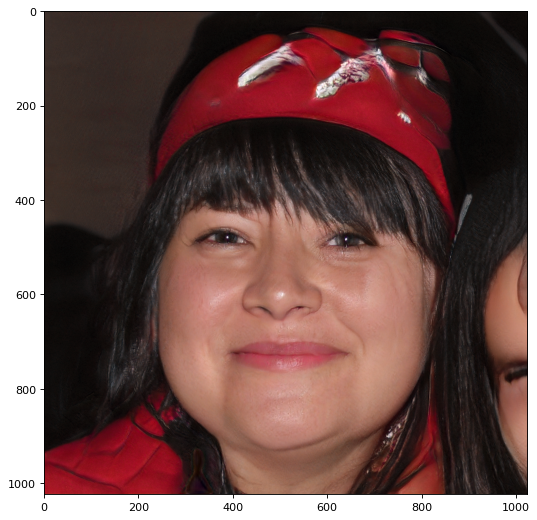

In [ ]:
# 랜덤한 latent vector z를 샘플링하기
z = torch.randn((1, 512), requires_grad=False, device=device)

# Z에서 W 공간으로 매핑(mapping)
w = g_mapping(z)

# 만들어진 이미지는 [-1, 1]의 범위를 가지므로 이를 조정하여 시각화
image = g_synthesis(w)
image = ((image + 1.0) / 2.0).clamp(0, 1)

imshow(image)

[ 첫 번째 이미지 출력 ]


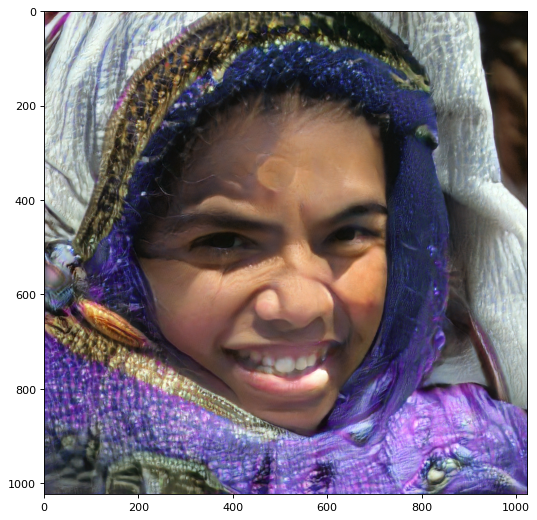

[ 두 번째 이미지를 출력 ]


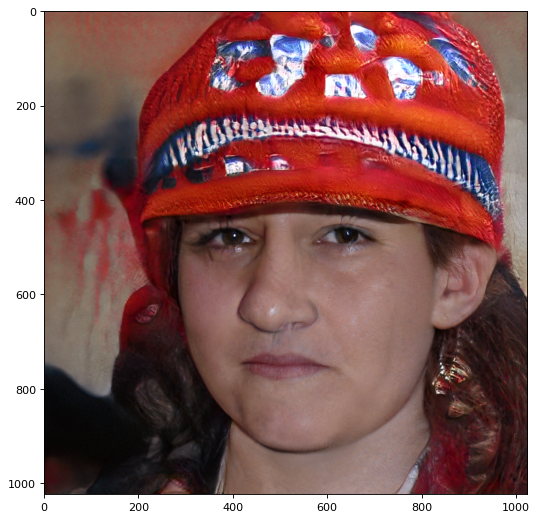

In [ ]:
# 첫 번째 w 벡터를 생성하여 시각화
print('[ 첫 번째 이미지 출력 ]')

z_1 = torch.randn((1, 512), requires_grad=False, device=device)
w_1 = g_mapping(z_1)

image = g_synthesis(w_1)
image = ((image + 1.0) / 2.0).clamp(0, 1)
imshow(image)

# 두 번째 w 벡터를 생성하여 시각화
print('[ 두 번째 이미지를 출력 ]')
z_2 = torch.randn((1, 512), requires_grad=False, device=device)
w_2 = g_mapping(z_2)

image = g_synthesis(w_2)
image = ((image + 1.0) / 2.0).clamp(0, 1)
imshow(image)

[ 이미지 보간법(Interpolation) ]


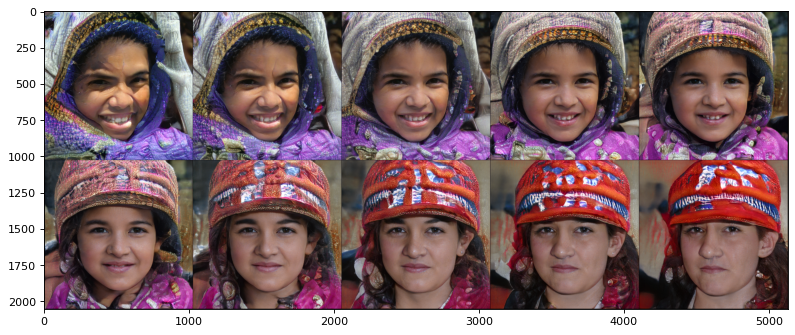

In [ ]:
# 이미지 보간 수행
print('[ 이미지 보간법(Interpolation) ]')

name = 'interpolation'
interpolated_images = []

with torch.no_grad(): # GPU 용량 낭비를 줄이기 위해 기울기를 추적하지 않도록 하기
    for alpha in np.linspace(0, 1, 10):
        w = (1 - alpha) * w_1 + alpha * w_2
        image = g_synthesis(w)
        image = ((image + 1.0) / 2.0).clamp(0, 1)
        interpolated_images.append(image)

# 결과 이미지를 격자(grid) 형태로 저장
grid_image = torchvision.utils.make_grid(torch.cat(interpolated_images, dim=0), nrow=5)
save_image(grid_image, f"{name}.png")
imshow(grid_image)

[ Fine Style Transfer ]


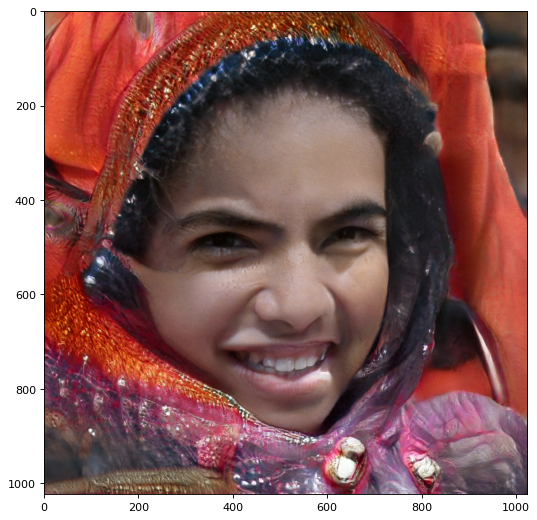

In [ ]:
# Source A + Fine Styles from B 시각화
print('[ Fine Style Transfer ]')

w = torch.cat((w_1[:,:8,:], w_2[:,8:,:]), dim=1)
image = g_synthesis(w)
image = ((image + 1.0) / 2.0).clamp(0, 1)
imshow(image)

[ Middle Style Transfer ]


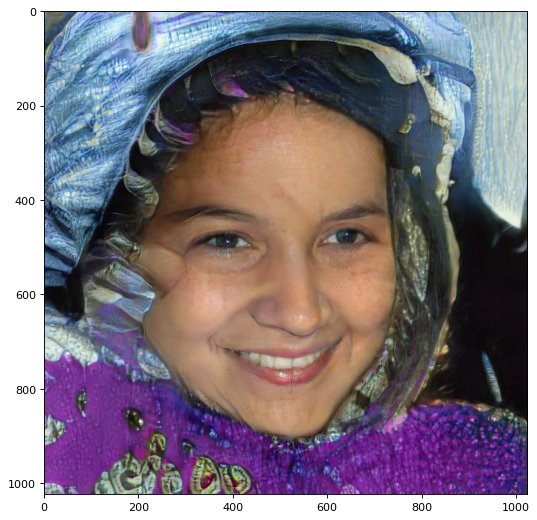

In [ ]:
# Source A + Middle Styles from B 시각화
print('[ Middle Style Transfer ]')

w = torch.cat((w_1[:,:4,:], w_2[:,4:8,:], w_1[:,8:,:]), dim=1)
image = g_synthesis(w)
image = ((image + 1.0) / 2.0).clamp(0, 1)
imshow(image)

[ Coarse Style Transfer ]


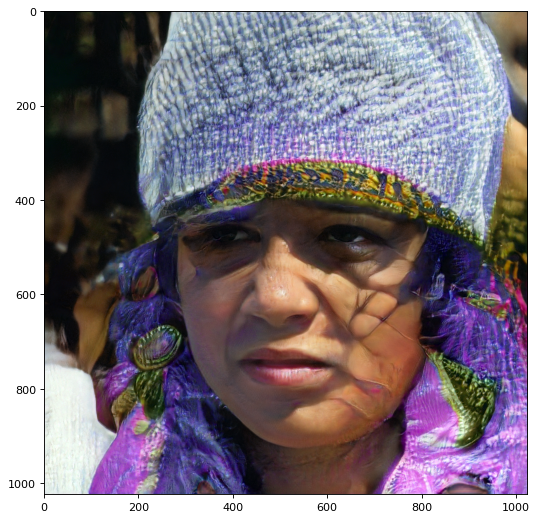

In [ ]:
# Source A + Coarse Styles from B 시각화
print('[ Coarse Style Transfer ]')

w = torch.cat((w_2[:,:4,:], w_1[:,4:,:]), dim=1)
image = g_synthesis(w)
image = ((image + 1.0) / 2.0).clamp(0, 1)
imshow(image)

In [ ]:
import warnings
warnings.filterwarnings(action='ignore') # 경고(warning) 메시지 보이지 않도록 하기


# VGG를 활용한 특징 추출기(Feature Extractor)
class FeatureExtractor(torch.nn.Module):
    def __init__(self, n_layers):
        super(FeatureExtractor, self).__init__()
        extractor = models.vgg16(pretrained=True).features

        # 각 레이어까지의 출력 값을 계산 (n_layers=[1, 3, 13, 20])
        index = 0
        self.layers = nn.ModuleList([])
        for i in range(len(n_layers)):
            # 해당 레이어까지의 출력 값을 내보낼 수 있도록 하기
            self.layers.append(torch.nn.Sequential())
            for j in range(index, n_layers[i] + 1):
                self.layers[i].add_module(str(j), extractor[j])
            index = n_layers[i] + 1

        # 모델을 학습할 필요는 없으므로 기울기 추적 중지
        for param in self.parameters():
            param.requires_grad = False

    # 각 레이어까지의 출력 값들을 리스트에 담아 반환
    def forward(self, x):
        result = []
        for i in range(len(self.layers)):
            x = self.layers[i](x)
            result.append(x)

        return result

In [ ]:
# 생성된 이미지(generated_image)와 대상 이미지(target_image)에 대한 손실(loss)을 계산
def loss_function(generated_image, target_image, feature_extractor):
    MSE = nn.MSELoss(reduction='mean')
    mse_loss = MSE(generated_image, target_image) # 손실(loss) 값 계산

    # VGG 네트워크의 입력은 256이므로, 크기를 256으로 바꾸는 업샘플링(upsampling)을 이용합니다.
    upsample2d = torch.nn.Upsample(scale_factor=256 / resolution, mode='bilinear')
    real_features = feature_extractor(upsample2d(target_image))
    generated_features = feature_extractor(upsample2d(generated_image))

    perceptual_loss = 0
    # 활성화 맵(activation map)의 개수만큼 반복하며
    for i in range(len(real_features)):
        perceptual_loss += MSE(real_features[i], generated_features[i]) # 손실(loss) 값 계산

    return mse_loss, perceptual_loss

Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth


  0%|          | 0.00/528M [00:00<?, ?B/s]

[iter 1/1500] loss = 8.072526931762695, saved_path = barack_obama_1.png
[iter 100/1500] loss = 1.8045583963394165, saved_path = barack_obama_100.png
[iter 200/1500] loss = 1.411607265472412, saved_path = barack_obama_200.png
[iter 300/1500] loss = 1.1750465631484985, saved_path = barack_obama_300.png
[iter 400/1500] loss = 1.022487759590149, saved_path = barack_obama_400.png
[iter 500/1500] loss = 0.9309378266334534, saved_path = barack_obama_500.png
[iter 600/1500] loss = 0.8888938426971436, saved_path = barack_obama_600.png
[iter 700/1500] loss = 0.9051535129547119, saved_path = barack_obama_700.png
[iter 800/1500] loss = 0.8071842193603516, saved_path = barack_obama_800.png
[iter 900/1500] loss = 0.833150327205658, saved_path = barack_obama_900.png
[iter 1000/1500] loss = 0.7808673977851868, saved_path = barack_obama_1000.png
[iter 1100/1500] loss = 0.7828320264816284, saved_path = barack_obama_1100.png
[iter 1200/1500] loss = 0.7430278658866882, saved_path = barack_obama_1200.png
[

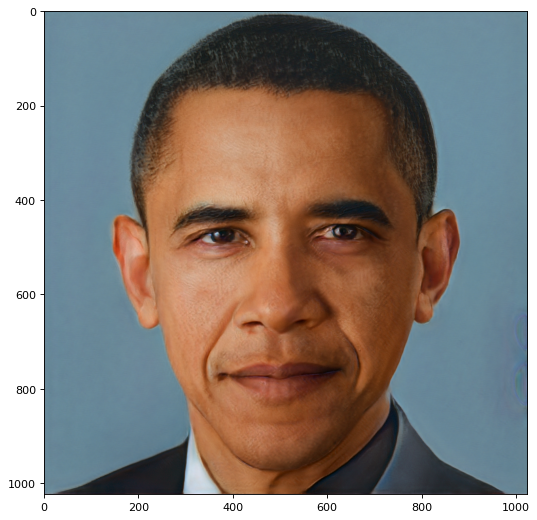

In [ ]:
latent = torch.zeros((1, 18, 512), requires_grad=True, device=device) # 업데이트할 latent vector 변수
optimizer_latent = optim.Adam({latent}, lr=0.02, betas=(0.9, 0.999), eps=1e-8)

# VGG perceptual loss를 위한 레이어 명시
feature_extractor = FeatureExtractor(n_layers=[1, 3, 13, 20]).to(device)

# 이미지 불러오기
src = 'images/barack_obama.jpg'
name = 'barack_obama'
image = image_reader(src, resize=resolution)
image = image.to(device)

# 최적화(optimization) 시작
iteration = 1500
for i in range(iteration):
    optimizer_latent.zero_grad()

    # latent vector를 이용해 이미지 생성
    generated_image = g_synthesis(latent)
    generated_image = (generated_image + 1.0) / 2.0
    generated_image = generated_image.clamp(0, 1)

    # 손실(loss) 값 계산
    loss = 0
    mse_loss, perceptual_loss = loss_function(generated_image, image, feature_extractor)
    loss += mse_loss + perceptual_loss
    loss.backward() # 기울기(gradient) 계산

    optimizer_latent.step() # latent vector 업데이트

    # 주기적으로 손실(loss) 값 및 이미지 출력
    if i == 0 or (i + 1) % 100 == 0:
        print(f'[iter {i + 1}/{iteration}] loss = {loss.detach().cpu().numpy()}, saved_path = {name}_{i + 1}.png')
        save_image(generated_image, f'{name}_{i + 1}.png')
        np.save(f'{name}_latent.npy', latent.detach().cpu().numpy())

print("[ 임베딩 결과 ]")
imshow(generated_image)

[iter 1/1500] loss = 8.074063301086426, saved_path = hugh_jackman_1.png
[iter 100/1500] loss = 2.7418394088745117, saved_path = hugh_jackman_100.png
[iter 200/1500] loss = 2.0775887966156006, saved_path = hugh_jackman_200.png
[iter 300/1500] loss = 1.8656026124954224, saved_path = hugh_jackman_300.png
[iter 400/1500] loss = 1.699593186378479, saved_path = hugh_jackman_400.png
[iter 500/1500] loss = 1.647863745689392, saved_path = hugh_jackman_500.png
[iter 600/1500] loss = 1.5672261714935303, saved_path = hugh_jackman_600.png
[iter 700/1500] loss = 1.4860711097717285, saved_path = hugh_jackman_700.png
[iter 800/1500] loss = 1.4461581707000732, saved_path = hugh_jackman_800.png
[iter 900/1500] loss = 1.421518325805664, saved_path = hugh_jackman_900.png
[iter 1000/1500] loss = 1.4233317375183105, saved_path = hugh_jackman_1000.png
[iter 1100/1500] loss = 1.437573790550232, saved_path = hugh_jackman_1100.png
[iter 1200/1500] loss = 1.3321329355239868, saved_path = hugh_jackman_1200.png
[i

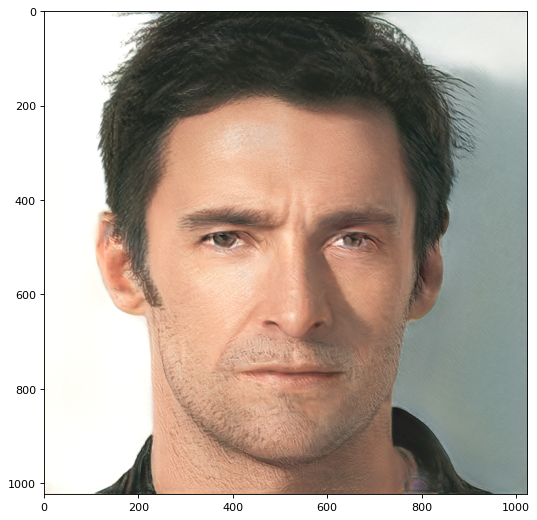

In [ ]:
latent = torch.zeros((1, 18, 512), requires_grad=True, device=device) # 업데이트할 latent vector 변수
optimizer_latent = optim.Adam({latent}, lr=0.02, betas=(0.9, 0.999), eps=1e-8)

# VGG perceptual loss를 위한 레이어 명시
feature_extractor = FeatureExtractor(n_layers=[1, 3, 13, 20]).to(device)

# 이미지 불러오기
src = 'images/hugh_jackman.jpg'
name = 'hugh_jackman'
image = image_reader(src, resize=resolution)
image = image.to(device)

# 최적화(optimization) 시작
iteration = 1500
for i in range(iteration):
    optimizer_latent.zero_grad()

    # latent vector를 이용해 이미지 생성
    generated_image = g_synthesis(latent)
    generated_image = (generated_image + 1.0) / 2.0
    generated_image = generated_image.clamp(0, 1)

    # 손실(loss) 값 계산
    loss = 0
    mse_loss, perceptual_loss = loss_function(generated_image, image, feature_extractor)
    loss += mse_loss + perceptual_loss
    loss.backward() # 기울기(gradient) 계산

    optimizer_latent.step() # latent vector 업데이트

    # 주기적으로 손실(loss) 값 및 이미지 출력
    if i == 0 or (i + 1) % 100 == 0:
        print(f'[iter {i + 1}/{iteration}] loss = {loss.detach().cpu().numpy()}, saved_path = {name}_{i + 1}.png')
        save_image(generated_image, f'{name}_{i + 1}.png')
        np.save(f'{name}_latent.npy', latent.detach().cpu().numpy())

print("[ 임베딩 결과 ]")
imshow(generated_image)

In [ ]:
#### 두 이미지간 모핑(Morphing) 구현하기

[ 이미지 보간법(Interpolation) ]


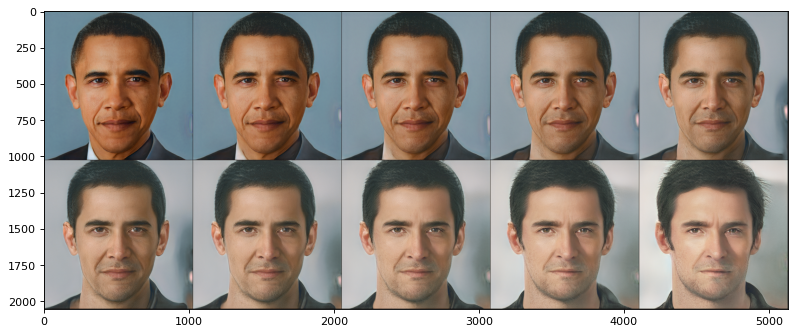

In [ ]:
print('[ 이미지 보간법(Interpolation) ]')

# .npy 파일로부터 두 w 벡터 불러오기
w_1 = np.load('barack_obama_latent.npy')
w_2 = np.load('hugh_jackman_latent.npy')

name = 'interpolation'
interpolated_images = []

# 두 벡터간 모핑(morphing) 수행하기
with torch.no_grad(): # GPU 용량 낭비를 줄이기 위해 기울기를 추적하지 않도록 하기
    for alpha in np.linspace(0, 1, 10):
        w = (1 - alpha) * w_1 + alpha * w_2
        w = torch.tensor(w).to(device)
        image = g_synthesis(w)
        image = ((image + 1.0) / 2.0).clamp(0, 1)
        interpolated_images.append(image)

# 결과 이미지를 격자(grid) 형태로 저장
grid_image = torchvision.utils.make_grid(torch.cat(interpolated_images, dim=0), nrow=5)
save_image(grid_image, f"{name}.png")
imshow(grid_image)

## Step 3. 얼굴 교차(Crossover)
#### 핵심 아이디어 설명.

* 마스크 이미지를 이용해 원하는 부분에 대하여 선택적으로 이미지 임베딩을 수행할 수 있다. 임베딩이란 얼굴을 조합한다는 의미로 이해하면 편하다.
* 두 얼굴을 이용하여 하나의 이미지에 임베딩을 수행할 수 있다.

### 얼굴 교차를 수행하는 알고리즘은 다음과 같다.
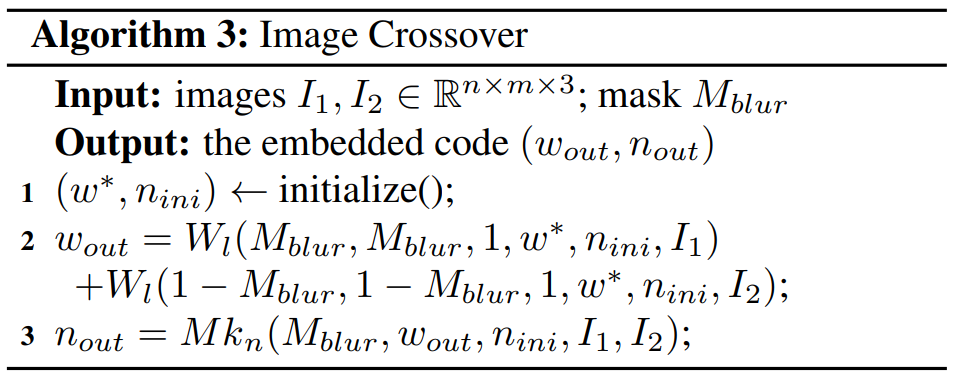

### 자 이제 마스크를 준비해 보자.

[ Image 1 ]


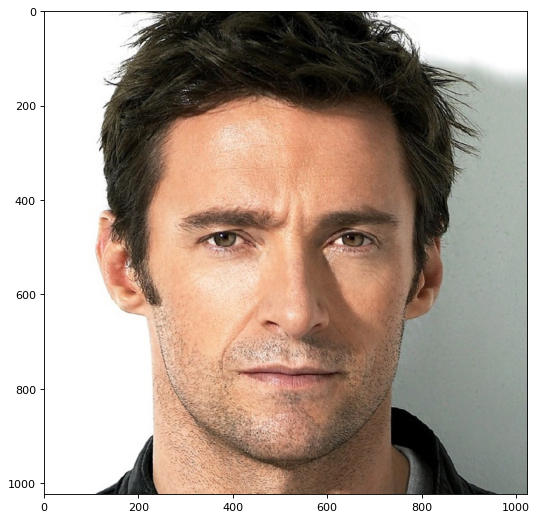

[ Image 2 ]


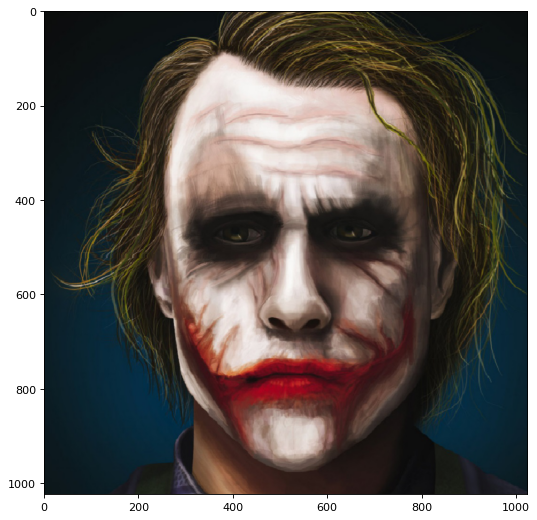

[ Mask ]


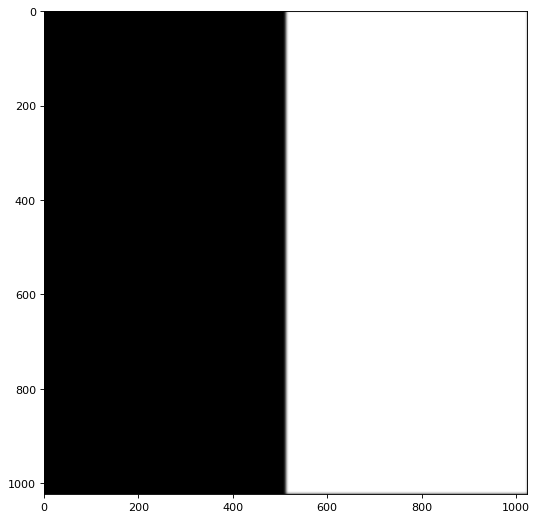

[ Mask Inverse ]


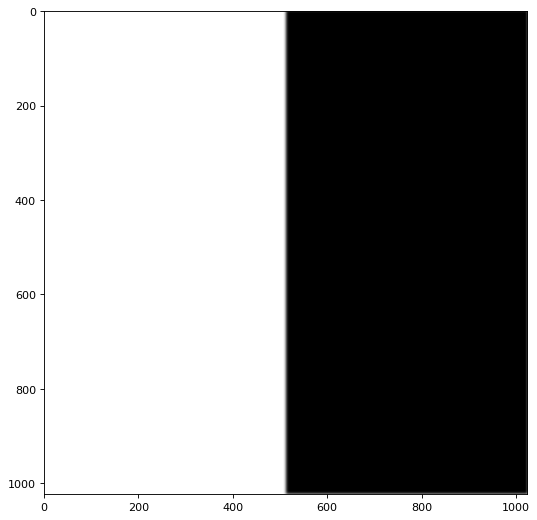

In [ ]:
# 이미지 A 불러오기
src_1 = 'images/hugh_jackman.jpg'
image_1 = image_reader(src_1, resize=resolution)
image_1 = image_1.to(device)
print('[ Image 1 ]')
imshow(image_1)

# 이미지 B 불러오기 
src_2 = 'images/joker.jpg'
image_2 = image_reader(src_2, resize=resolution)
image_2 = image_2.to(device)
print('[ Image 2 ]')
imshow(image_2)

# 교차(crossover) 이미지 생성을 위한 마스크 이미지 불러오기
mask_src = 'images/blur_mask.png'
mask = image_reader(mask_src, resize=resolution)
mask = mask.to(device)
mask = mask[:, 0, :, :].unsqueeze(0)
mask_inverse = mask.clone()
mask_inverse = 1 - mask

# 마스크 시각화
print('[ Mask ]')
imshow(mask)

# 인버스(inverse) 마스크 시각화
print('[ Mask Inverse ]')
imshow(mask_inverse)

## 마스크(Mask)를 고려하는 손실(Loss) 함수 구현하기

In [ ]:
# 생성된 이미지(generated_image)와 대상 이미지(target_image)에 대한 손실(loss)을 계산(마스크 고려)
def loss_function_with_mask(generated_image, target_image, feature_extractor, mask):
    MSE = nn.MSELoss(reduction='mean')
    # 마스크가 씌워진 부분에 대한 MSE 손실(loss) 계산
    mse_loss = MSE(generated_image * mask.expand(1, 3, resolution, resolution), target_image * mask.expand(1, 3, resolution, resolution))

    # VGG 네트워크의 입력은 256이므로, 크기를 256으로 바꾸는 업샘플링(upsampling)을 이용합니다.
    upsample2d = torch.nn.Upsample(scale_factor=256 / resolution, mode='bilinear')
    real_features = feature_extractor(upsample2d(target_image))
    generated_features = feature_extractor(upsample2d(generated_image))

    perceptual_loss = 0
    # 활성화 맵(activation map)의 개수만큼 반복하며
    for i in range(len(real_features)):
        mask_shape = mask.shape
        feature_shape = real_features[i].shape # 현재 특징 맵(feature map) 크기 구하기 (shape[2]는 높이를 의미)
        mask = torch.nn.Upsample(scale_factor=feature_shape[2] / mask_shape[2], mode='bilinear')(mask) # 특징 맵의 크기에 맞추기
        # 마스크가 씌워진 부분에 대한 손실(loss) 계산
        perceptual_loss += MSE(real_features[i] * mask.expand(feature_shape), generated_features[i] * mask.expand(feature_shape)) # 손실(loss) 값 계산

    return mse_loss, perceptual_loss

## 얼굴 교차 실습

[iter 1/1500] loss = 8.416604042053223, saved_path = crossover_1.png
[iter 100/1500] loss = 3.6499452590942383, saved_path = crossover_100.png
[iter 200/1500] loss = 2.8797688484191895, saved_path = crossover_200.png
[iter 300/1500] loss = 2.6087379455566406, saved_path = crossover_300.png
[iter 400/1500] loss = 2.3350613117218018, saved_path = crossover_400.png
[iter 500/1500] loss = 2.218017101287842, saved_path = crossover_500.png
[iter 600/1500] loss = 2.0966620445251465, saved_path = crossover_600.png
[iter 700/1500] loss = 2.018460750579834, saved_path = crossover_700.png
[iter 800/1500] loss = 2.00454044342041, saved_path = crossover_800.png
[iter 900/1500] loss = 1.9594199657440186, saved_path = crossover_900.png
[iter 1000/1500] loss = 1.902270793914795, saved_path = crossover_1000.png
[iter 1100/1500] loss = 1.8703423738479614, saved_path = crossover_1100.png
[iter 1200/1500] loss = 1.8010897636413574, saved_path = crossover_1200.png
[iter 1300/1500] loss = 1.8219962120056152

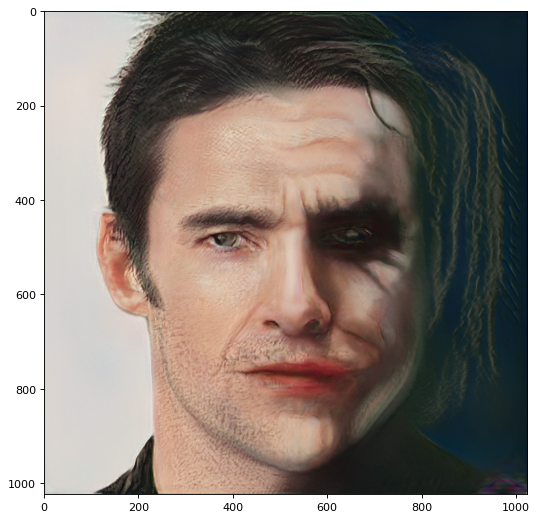

In [ ]:
latent = torch.zeros((1, 18, 512), requires_grad=True, device=device) # 업데이트할 latent vector 변수
optimizer_latent = optim.Adam({latent}, lr=0.02, betas=(0.9, 0.999), eps=1e-8)

# VGG perceptual loss를 위한 레이어 명시
feature_extractor = FeatureExtractor(n_layers=[1, 3, 13, 20]).to(device)

name = 'crossover'

# 최적화(optimization) 시작
iteration = 1500
for i in range(iteration):
    optimizer_latent.zero_grad()

    # latent vector를 이용해 이미지 생성
    generated_image = g_synthesis(latent)
    generated_image = (generated_image + 1.0) / 2.0
    generated_image = generated_image.clamp(0, 1)

    # 손실(loss) 값 계산
    loss = 0
    mse_loss_1, perceptual_loss_1 = loss_function_with_mask(generated_image, image_1, feature_extractor, mask_inverse)
    mse_loss_2, perceptual_loss_2 = loss_function_with_mask(generated_image, image_2, feature_extractor, mask)
    loss += mse_loss_1 + perceptual_loss_1 + mse_loss_2 + perceptual_loss_2
    loss.backward() # 기울기(gradient) 계산

    optimizer_latent.step() # latent vector 업데이트

    # 주기적으로 손실(loss) 값 및 이미지 출력
    if i == 0 or (i + 1) % 100 == 0:
        print(f'[iter {i + 1}/{iteration}] loss = {loss.detach().cpu().numpy()}, saved_path = {name}_{i + 1}.png')
        save_image(generated_image, f'{name}_{i + 1}.png')
        np.save(f'{name}_latent.npy', latent.detach().cpu().numpy())

print("[ 교차(Crossover) 결과 ]")
save_image(generated_image, f"{name}.png")
imshow(generated_image)

## 조커와 휴 잭맨의 얼굴을 합성해냈다.

## 추가 설명
* 일반적인 GAN과 마찬가지로 StyleGAN에서도 Latent Vector 간의 연산을 수행할 수 있다.
* 웃는 얼굴(Smile Face)에서 무표정 얼굴(Neutral Face)을 빼서 웃는 얼굴에 대한 시맨틱(semantic) 정보를 얻을 수 있다.

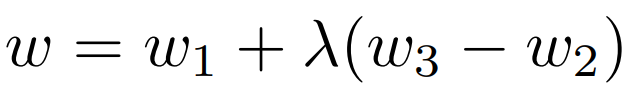